# Feature Engineering 2: Dimensionality and PCA

## <br>By Jean-Philippe Pitteloud</br>

### Requirements

In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
%matplotlib inline

warnings.filterwarnings('ignore')

### Data Gathering

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

edu_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing 
engine.dispose()

In [3]:
edu_df.tail()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
1487,2017_VIRGINIA,VIRGINIA,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,248.041059,290.081407,227.598382,273.402640
1488,2017_WASHINGTON,WASHINGTON,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,241.701001,289.131257,223.123409,267.744778
1489,2017_WEST_VIRGINIA,WEST_VIRGINIA,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,236.057019,273.415854,217.316396,271.617023
1490,2017_WISCONSIN,WISCONSIN,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,240.389213,288.143144,219.612694,258.700304
1491,2017_WYOMING,WYOMING,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,247.820619,288.761812,226.831211,269.371456


### Data Cleaning

In [4]:
edu_df_cleaned = edu_df.copy()

In [5]:
edu_df_cleaned.drop('PRIMARY_KEY', axis = 1, inplace = True)

In [6]:
edu_df_cleaned['STATE'] = edu_df_cleaned['STATE'].str.replace('_-_', '_')

edu_df_cleaned['bureau'] = edu_df_cleaned['STATE'].str.contains('^[B][UREAU]{5}\w+|^[B][I][E]?', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['bureau'], 'BUREAU_OF_INDIAN_EDUCATION', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('bureau', axis = 1, inplace = True)

edu_df_cleaned['maria'] = edu_df_cleaned['STATE'].str.contains('NORTHERN_MARIANAS|COMMONWEALTH_OF_MARIANAS|MARIANAS|^[M][P]$', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['maria'], 'NORTHERN_MARIANA_ISLANDS', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('maria', axis = 1, inplace = True)

edu_df_cleaned['dod'] = edu_df_cleaned['STATE'].str.contains('DEPARTMENT|DOD|DD', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['dod'], 'DEPARTMENT_OF_DEFENSE', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('dod', axis = 1, inplace = True)

edu_df_cleaned['as'] = edu_df_cleaned['STATE'].str.contains('AMERICAN_SAMOA|^[A][S]', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['as'], 'AMERICAN_SAMOA', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('as', axis = 1, inplace = True)

edu_df_cleaned['guam'] = edu_df_cleaned['STATE'].str.contains('GUAM|^[G][U]', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['guam'], 'GUAM', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('guam', axis = 1, inplace = True)

edu_df_cleaned['pr'] = edu_df_cleaned['STATE'].str.contains('PUERTO_RICO|^[P][R]', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['pr'], 'PUERTO_RICO', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('pr', axis = 1, inplace = True)

edu_df_cleaned['vi'] = edu_df_cleaned['STATE'].str.contains('VIRGIN_ISLANDS|^[V][I]$', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['vi'], 'VIRGIN_ISLANDS', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('vi', axis = 1, inplace = True)

In [8]:
columns = ['ENROLL', 'TOTAL_REVENUE', 'FEDERAL_REVENUE',
       'STATE_REVENUE', 'LOCAL_REVENUE', 'TOTAL_EXPENDITURE',
       'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE',
       'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G',
       'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G',
       'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE',
       'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE'] 

states = edu_df_cleaned['STATE'].unique()

for state in states:
    edu_df_cleaned.loc[edu_df_cleaned['STATE'] == state, columns] = edu_df_cleaned.loc[edu_df_cleaned["STATE"] == state, columns].interpolate()

edu_df_cleaned.dropna(inplace=True)

In [9]:
edu_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046 entries, 54 to 1491
Data columns (total 24 columns):
STATE                           1046 non-null object
YEAR                            1046 non-null int64
ENROLL                          1046 non-null float64
TOTAL_REVENUE                   1046 non-null float64
FEDERAL_REVENUE                 1046 non-null float64
STATE_REVENUE                   1046 non-null float64
LOCAL_REVENUE                   1046 non-null float64
TOTAL_EXPENDITURE               1046 non-null float64
INSTRUCTION_EXPENDITURE         1046 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1046 non-null float64
OTHER_EXPENDITURE               1046 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1046 non-null float64
GRADES_PK_G                     1046 non-null float64
GRADES_KG_G                     1046 non-null float64
GRADES_4_G                      1046 non-null float64
GRADES_8_G                      1046 non-null float64
GRADES_12_G                    

**1. Create a new score variable from the weighted averages of the all score variables in the datasets. Notice that the number of students in the fourth grade isn't the same with the number of students in the eighth grade. So, you should weight the scores appropriately!**

In order to create a weighted average score feature, the differences in population between the two groups, 4th graders and 8th graders, need to be considered using the contribution (proportion) of each group to the total

In [10]:
edu_df_cleaned["overall_score"] = (edu_df_cleaned["GRADES_4_G"] * ((edu_df_cleaned["AVG_MATH_4_SCORE"] + edu_df_cleaned["AVG_READING_4_SCORE"]) * 0.5) + edu_df_cleaned["GRADES_8_G"] * ((edu_df_cleaned["AVG_MATH_8_SCORE"] + edu_df_cleaned["AVG_READING_8_SCORE"])*0.5)) / (edu_df_cleaned["GRADES_4_G"] + edu_df_cleaned["GRADES_8_G"])

**2. What are the correlations between this newly created score variable and the expenditure types? Which one of the expenditure type is more correlated than the others?**

In [13]:
corr_mat = edu_df_cleaned[["overall_score", "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]].corr()
corr_mat

,overall_score,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
overall_score,1.000000,0.093020,0.105787,0.098643,0.027635,0.010670
TOTAL_EXPENDITURE,0.093020,1.000000,0.990829,0.993175,0.946483,0.928576
INSTRUCTION_EXPENDITURE,0.105787,0.990829,1.000000,0.975867,0.907235,0.889763
SUPPORT_SERVICES_EXPENDITURE,0.098643,0.993175,0.975867,1.000000,0.953789,0.913680
OTHER_EXPENDITURE,0.027635,0.946483,0.907235,0.953789,1.000000,0.924197
CAPITAL_OUTLAY_EXPENDITURE,0.010670,0.928576,0.889763,0.913680,0.924197,1.000000


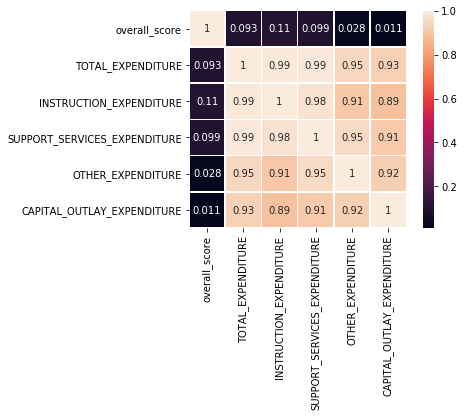

In [15]:
sns.heatmap(corr_mat, square=True, annot=True, linewidths=.5);

As it can be seen in the table and chart above, all expenditure variables exhibit positive but weak correlation the newly created variable, 'overall_score'. Among the expenditure variables, 'INSTRUCTION_EXPENDITURE' shows the strongest correlation to the target variable

**3. Now, apply PCA to the four expenditure types. How much of the total variance is explained by the first component?**

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_mat = edu_df_cleaned[["INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]]

X_mat = StandardScaler().fit_transform(X_mat)

sklearn_pca = PCA(n_components=1)
edu_df_cleaned["pca_1"] = sklearn_pca.fit_transform(X_mat)

print('The percentage of total variance in the dataset explained by each component from Sklearn PCA.\n', sklearn_pca.explained_variance_ratio_)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.94568116]


From the result above, a proportion of 0.946 (95 %) of the variance is effectively explanied by the first Principal Component calculated from the variables specified above

**4. What is the correlation between the overall score variable and the first principal component?**

In [41]:
corr_mat2 = edu_df_cleaned[["overall_score", "pca_1", "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]].corr()
corr_mat2

,overall_score,pca_1,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
overall_score,1.000000,0.062716,0.093020,0.105787,0.098643,0.027635,0.010670
pca_1,0.062716,1.000000,0.992264,0.970167,0.988317,0.973193,0.957927
TOTAL_EXPENDITURE,0.093020,0.992264,1.000000,0.990829,0.993175,0.946483,0.928576
INSTRUCTION_EXPENDITURE,0.105787,0.970167,0.990829,1.000000,0.975867,0.907235,0.889763
SUPPORT_SERVICES_EXPENDITURE,0.098643,0.988317,0.993175,0.975867,1.000000,0.953789,0.913680
OTHER_EXPENDITURE,0.027635,0.973193,0.946483,0.907235,0.953789,1.000000,0.924197
CAPITAL_OUTLAY_EXPENDITURE,0.010670,0.957927,0.928576,0.889763,0.913680,0.924197,1.000000


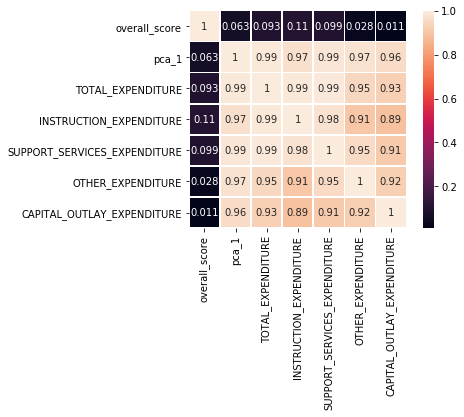

In [42]:
sns.heatmap(corr_mat2, square=True, annot=True, linewidths=.5);

From the table and chart displayed above, it can be seen that the correlation between the target variable 'overall_score' and the first Principal Component calculated is 0.063. This value is smaller than the most correlated variable in the original dataset, the 'INSTRUCTION_EXPENDITURE' variable 

**5. If you were to choose the best variables for your model, would you prefer using the first principal component instead of the expenditure variables? Why?**

Since the correlation exhibited between the taget varible and the Principal Component of all the expenditure variables was weaker and the estimation of the correlation between the taget and the 'INSTRUCTION_EXPENDITURE' variable, I will likely support my model in the use of the 'INSTRUCTION_EXPENDITURE' variable